In [1]:
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16
import numpy as np
import matplotlib.pyplot as plt
import os
os.environ['KMP_DUPLICATE_LIB_OK'] = '1'

In [2]:
b_size = 5

train_datagen = ImageDataGenerator(rescale=1./255,
                                  horizontal_flip=True,
                                  width_shift_range=0.1,
                                  height_shift_range=0.1,
                                  fill_mode='nearest')

train_generator = train_datagen.flow_from_directory(
    'data/train',
    target_size=(150, 150),
    batch_size=b_size,
    class_mode='binary'
)

Found 160 images belonging to 2 classes.


In [3]:
val_datagen = ImageDataGenerator(rescale=1./255) #원래 데이터가 들어와서 validation data가 되어야하므로 
val_generator = val_datagen.flow_from_directory(
    'data/test',
    target_size=(150, 150),
    batch_size=b_size,
    class_mode='binary'
)

Found 120 images belonging to 2 classes.


In [4]:
transfer_model = VGG16(weights='imagenet', include_top=False, input_shape=(150, 150, 3))
transfer_model.trainable = False
transfer_model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 150, 150, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 150, 150, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 150, 150, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 75, 75, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 75, 75, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 75, 75, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 37, 37, 128)       0     

In [5]:
finetune_model = keras.Sequential()
finetune_model.add(transfer_model)
finetune_model.add(keras.layers.Flatten())
finetune_model.add(keras.layers.Dense(64, activation='relu'))
finetune_model.add(keras.layers.Dense(2, activation='softmax'))
finetune_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 4, 4, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 8192)              0         
                                                                 
 dense (Dense)               (None, 64)                524352    
                                                                 
 dense_1 (Dense)             (None, 2)                 130       
                                                                 
Total params: 15,239,170
Trainable params: 524,482
Non-trainable params: 14,714,688
_________________________________________________________________


In [6]:
finetune_model.compile(loss='sparse_categorical_crossentropy',
              optimizer=keras.optimizers.Adam(learning_rate=0.0002), metrics=['accuracy'])

In [7]:
history = finetune_model.fit(
       train_generator,
       epochs=20,
       validation_data=val_generator)

Epoch 1/20
32/32 [==============================] - 8s 241ms/step - loss: 0.6370 - accuracy: 0.6500 - val_loss: 0.6139 - val_accuracy: 0.6250
Epoch 2/20
32/32 [==============================] - 7s 226ms/step - loss: 0.4386 - accuracy: 0.7688 - val_loss: 0.3460 - val_accuracy: 0.8583
Epoch 3/20
32/32 [==============================] - 7s 218ms/step - loss: 0.2451 - accuracy: 0.9563 - val_loss: 0.2440 - val_accuracy: 0.9250
Epoch 4/20
32/32 [==============================] - 7s 219ms/step - loss: 0.2163 - accuracy: 0.9625 - val_loss: 0.2484 - val_accuracy: 0.8917
Epoch 5/20
32/32 [==============================] - 7s 235ms/step - loss: 0.2198 - accuracy: 0.9500 - val_loss: 0.1850 - val_accuracy: 0.9667
Epoch 6/20
32/32 [==============================] - 7s 235ms/step - loss: 0.1489 - accuracy: 0.9688 - val_loss: 0.1598 - val_accuracy: 0.9583
Epoch 7/20
32/32 [==============================] - 7s 227ms/step - loss: 0.1494 - accuracy: 0.9688 - val_loss: 0.1598 - val_accuracy: 0.9500
Epoch 

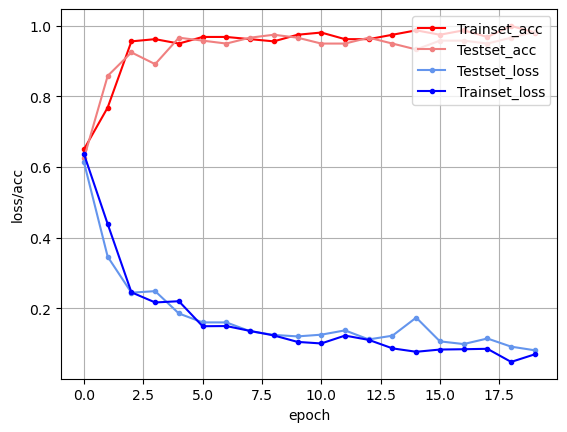

In [8]:
acc= history.history['accuracy']
val_acc= history.history['val_accuracy']
y_vloss = history.history['val_loss']
y_loss = history.history['loss']

x_len = np.arange(len(y_loss))  
plt.plot(x_len, acc, marker='.', c="red", label='Trainset_acc')
plt.plot(x_len, val_acc, marker='.', c="lightcoral", label='Testset_acc')
plt.plot(x_len, y_vloss, marker='.', c="cornflowerblue", label='Testset_loss')
plt.plot(x_len, y_loss, marker='.', c="blue", label='Trainset_loss')

plt.legend(loc='upper right') 
plt.grid()
plt.xlabel('epoch')
plt.ylabel('loss/acc')
plt.show()